In [ ]:
# # !pip install keras-tuner
# !pip install tensorflow
# !pip install numpy
# !pip install pandas

In [ ]:
#Importar as bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import math
import datetime
import time

# Importar sklearn para avaliar o modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing  import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
# from scikeras.wrappers import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# Importar tensorflow para construir o modelo
import tensorflow as tf
import keras
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# Importar bibliotecas para plotar gráficos

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



## Variaveis Globais

In [ ]:
TIME_STEP = 30              #número de dias usados para prever o futuro
JUMP_STEP = 1
NUM_FEATURES = 5
NUM_PREDICT_FUTURE = 1      #número do dia a serem preditos no futuro (prever o próximo dia? Prever o 7º dia?)
THRESHOLD = 3
PATH = './drive/MyDrive/TCC/single_lstm_classification18/'

## Definição das Seeds


In [ ]:
import tensorflow as tf
import numpy as np

# Defina a semente do TensorFlow
tf.random.set_seed(0)

# Defina a semente do NumPy
np.random.seed(0)


## Importar a Base de Dados

In [ ]:
ticker = 'BTC-USD'
#1410825600
initial_period = int(time.mktime(datetime.datetime(2014, 9, 16, 0, 0).timetuple()))

#1675814400
final_period = int(time.mktime(datetime.datetime(2023, 10, 31, 0, 0).timetuple()))
# 3067 valores. 2300 é 75%
interval = '1d' # 1d, 1wk, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={initial_period}&period2={final_period}&interval={interval}&events=history&includeAdjustedClose=true'

data = pd.read_csv(query_string)
df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')


Função para escolher os dados utilizados de forma sequencial. A cada t valores


In [ ]:
# def selecionaValores(df, jump_step):
#   return df[0::jump_step]

# df = selecionaValores(df, JUMP_STEP)

Preparação dos Dados:

In [ ]:
# Retira a Data e coloca como Index
df.index = df.pop('Date')

data.dropna(inplace=True)
data.reset_index(inplace = True)


In [ ]:
# Definir os dataframes dos objetivos a serem alcançados pelo modelo. O Y. Baseados no TimeStep e numero do dia a ser predito

ignoreDays = TIME_STEP + NUM_PREDICT_FUTURE - 1
index = np.array(df.index)[ignoreDays:]

# Dataframe com o valor de fechamento
target_df_Close = pd.DataFrame(df['Close'], index, ['Close']).rename(columns={'Close':'YClose'})

# Dataframe com a variação nominal entre os dias
array_change = np.array(target_df_Close.YClose) - np.array(df['Close'])[TIME_STEP-1 : -NUM_PREDICT_FUTURE]
target_df_Change = pd.DataFrame(array_change, index, columns=['Close']).rename(columns={'Close':'YChange'})

# Dataframe com a variação percentual entre os dias
array_variation = np.array(target_df_Change.YChange) / np.array(df['Close'])[TIME_STEP-1 : -NUM_PREDICT_FUTURE]
target_df_Variation = pd.DataFrame(array_variation*100, index, ['Close']).rename(columns={'Close':'YVariation'})


# Dataframe com a Classe baseado na variação percentual entre os dias

def defineClass(variation):
  if variation > THRESHOLD:
    return 2
  elif variation < -THRESHOLD:
    return 0
  else:
    return 1
# Apply the defineClass function to each data point in the array_variation
classifications = [defineClass(variation*100) for variation in array_variation]
target_df_Class = pd.DataFrame(classifications, index, ['Close']).rename(columns={'Close':'YClass'})


In [ ]:
# target_log = pd.DataFrame(np.log10(np.array(target_df_Close['YClose'])), index, ['YClose']).rename(columns={'YClose':'YLogClose'})
# final_df = pd.concat([target_df_Close, target_log, target_df_Change, target_df_Variation, target_df_Class], axis=1)

# final_df.head(5)

,YClose,YLogClose,YChange,YVariation,YClass
2014-10-17,383.757996,2.584057,1.201996,0.314201,1
2014-10-18,391.441986,2.592667,7.683990,2.002301,1
2014-10-19,389.545990,2.590559,-1.895996,-0.484362,1
2014-10-20,382.845001,2.583023,-6.700989,-1.720205,1
2014-10-21,386.475006,2.587121,3.630005,0.948166,1


In [ ]:
# # Imprimir informações sobre o tamanho das séries de dados
# print(f'df.Close.size: {df.Close.size}')
# print(f'target_df_Close.size: {target_df_Close.size}')
# print(f'target_df_Change.size: {target_df_Change.size}')
# print(f'target_df_Variation.size: {target_df_Variation.size}')
# print(f'target_df_Class.size: {target_df_Class.size}')
# print()

df.Close.size: 3332
target_df_Close.size: 3302
target_df_Change.size: 3302
target_df_Variation.size: 3302
target_df_Class.size: 3302



In [ ]:
# print("Target Class")
# class_counts = target_df_Class['YClass'].value_counts().sort_index()
# print(class_counts)
# print()

Target Class
0     414
1    2401
2     487
Name: YClass, dtype: int64



## Divisão em Treino, Validação e Teste

In [ ]:
# Divisão entre 70% treino, 10% validação e 20% teste
size = len(target_df_Class)
train_size = int(size * 0.7)
validation_size = int(size * 0.1)
test_size = size - train_size - validation_size

x_train_data = df[: train_size + TIME_STEP - 1]
x_val_data = df[ train_size : (train_size + validation_size + TIME_STEP - 1)]
x_test_data = df[train_size + validation_size : -NUM_PREDICT_FUTURE]

y_train_data = target_df_Class[: train_size]
y_val_data = target_df_Class[train_size : (train_size + validation_size)]
y_test_data = target_df_Class[(train_size + validation_size) :]


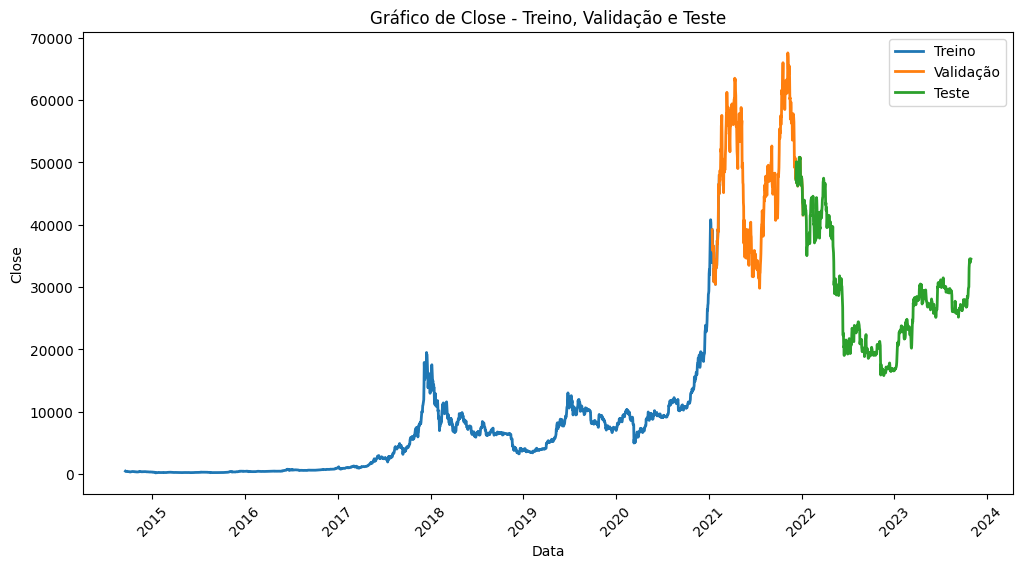

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Suponha que você tenha os DataFrames x_train_data, x_val_data e x_test_data
# # Vamos plotar a coluna "Close" de cada conjunto de dados

# plt.figure(figsize=(12, 6))  # Define o tamanho da figura

# # Converter o índice em uma série de datas
# x_train_dates = pd.to_datetime(x_train_data.index)
# x_val_dates = pd.to_datetime(x_val_data.index)
# x_test_dates = pd.to_datetime(x_test_data.index)

# # Plot da coluna "Close" do conjunto de treino
# plt.plot(x_train_dates, x_train_data['Close'], label='Treino', linewidth=2)

# # Plot da coluna "Close" do conjunto de validação
# plt.plot(x_val_dates, x_val_data['Close'], label='Validação', linewidth=2)

# # Plot da coluna "Close" do conjunto de teste
# plt.plot(x_test_dates, x_test_data['Close'], label='Teste', linewidth=2)

# plt.xlabel('Data')  # Rótulo do eixo x
# plt.ylabel('Close')  # Rótulo do eixo y
# plt.title('Gráfico de Close - Treino, Validação e Teste')  # Título do gráfico
# plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade
# plt.legend()  # Adiciona a legenda

# plt.show()  # Mostra o gráfico


In [ ]:
# # Imprimir informações sobre os tamanhos dos dados
# print('Tamanhos dos dados:')
# print(f'size: {size}')
# print(f'train_size: {train_size}')
# print(f'validation_size: {validation_size}')
# print(f'test_size: {test_size}')
# print()

Tamanhos dos dados:
size: 3302
train_size: 2311
validation_size: 330
test_size: 661



In [ ]:
# # Imprimir os tamanhos dos dados em linhas separadas
# print('x_train_data.shape:', x_train_data.shape)
# print('x_val_data.shape:', x_val_data.shape)
# print('x_test_data.shape:', x_test_data.shape)
# print('y_train_data.shape:', y_train_data.shape)
# print('y_val_data.shape:', y_val_data.shape)
# print('y_test_data.shape:', y_test_data.shape)
# print()

x_train_data.shape: (2340, 5)
x_val_data.shape: (359, 5)
x_test_data.shape: (690, 5)
y_train_data.shape: (2311, 1)
y_val_data.shape: (330, 1)
y_test_data.shape: (661, 1)



In [ ]:
#Transforma os dados para suavizar as variações em escala absoluta
# Transforma input data
scaler_train_input = MinMaxScaler(feature_range=(0, 1))
scaled_train_input = scaler_train_input.fit_transform(x_train_data)

scaled_val_input = scaler_train_input.transform(x_val_data)
scaled_test_input = scaler_train_input.transform(x_test_data)

# Transforma output data para o resultado
# encoded_train_output = keras.utils.to_categorical(y_train_data, num_classes=3)
# encoded_val_output = keras.utils.to_categorical(y_val_data, num_classes=3)
# encoded_test_output = keras.utils.to_categorical(y_test_data, num_classes=3)

encoded_train_output = np.array(y_train_data.astype(int))
encoded_val_output = np.array(y_val_data.astype(int))
encoded_test_output = np.array(y_test_data.astype(int))


In [ ]:
# import pandas as pd

# # Converter os arrays numpy em DataFrames
# scaled_train_df = pd.DataFrame(scaled_train_input, columns=x_train_data.columns)
# scaled_val_df = pd.DataFrame(scaled_val_input, columns=x_val_data.columns)
# scaled_test_df = pd.DataFrame(scaled_test_input, columns=x_test_data.columns)

# # Imprimir os 5 primeiros valores de cada DataFrame
# print("Dados de Treino (5 primeiros valores):")
# print(scaled_train_df.head(5))
# print()


# print("Dados de Validação (5 primeiros valores):")
# print(scaled_val_df.head(5))
# print()

# print("Dados de Teste (5 primeiros valores):")
# print(scaled_test_df.head(5))
# print()



Dados de Treino (5 primeiros valores):
       Open      High       Low     Close    Volume
0  0.006242  0.005315  0.006243  0.005850  0.000123
1  0.006048  0.005080  0.005369  0.005161  0.000232
2  0.005340  0.004479  0.004734  0.004540  0.000260
3  0.004704  0.004385  0.004853  0.004835  0.000251
4  0.004994  0.004159  0.004927  0.004624  0.000168

Dados de Validação (5 primeiros valores):
       Open      High       Low     Close    Volume
0  0.802461  0.823901  0.815573  0.817268  0.515835
1  0.842026  0.815846  0.766479  0.767784  0.549447
2  0.791585  0.780337  0.788125  0.754224  0.467911
3  0.777371  0.756670  0.753361  0.746119  0.424556
4  0.769348  0.768626  0.771463  0.763692  0.401459

Dados de Teste (5 primeiros valores):
       Open      High       Low     Close    Volume
0  1.025325  1.032160  1.041265  0.986046  0.251066
1  1.017170  1.020616  1.039457  1.030445  0.208977
2  1.062323  1.046867  1.079094  1.045861  0.177865
3  1.078737  1.036093  1.016177  0.975449  0.26

In [ ]:
def createDataset(x, y, time_step=1):
  input = []
  output = []
  for i in range(len(y)):
    row = np.array([e for e in x[i : i + time_step]])
    input.append(row)
    output.append(y[i])

  return np.array(input), np.array(output)

x_train, y_train = createDataset(scaled_train_input, encoded_train_output, TIME_STEP)
x_val, y_val = createDataset(scaled_val_input, encoded_val_output, TIME_STEP)
x_test, y_test = createDataset(scaled_test_input, encoded_test_output, TIME_STEP)



In [ ]:
# # Imprimir informações sobre as formas dos DataFrames e arrays
# print('Formas dos DataFrames e arrays:')
# print(f'df.shape: {df.shape}')
# print(f'x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}')
# print(f'x_val.shape: {x_val.shape}, y_val.shape: {y_val.shape}')
# print(f'x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}')
# print()

Formas dos DataFrames e arrays:
df.shape: (3332, 5)
x_train.shape: (2311, 30, 5), y_train.shape: (2311, 1)
x_val.shape: (330, 30, 5), y_val.shape: (330, 1)
x_test.shape: (661, 30, 5), y_test.shape: (661, 1)



## Construção do Modelo LSTM

### Random Search com LSTM



In [ ]:
import keras_tuner as kt
auc_metric = keras.metrics.AUC(name='auc')
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

def build_singleLayer_lstm_model(hp):
  model = keras.Sequential()
  model.add(LSTM(
      units=hp.Int('num_lstm_units', min_value=16, max_value=128, step=16),
      return_sequences=False,
      input_shape = (x_train.shape[1], x_train.shape[2]),
      # activation='softmax'
      ))
  model.add(Dropout(hp.Float('dropout_rate', min_value=0, max_value=0.4)))
  model.add(Dense(units=3, activation='softmax'))
  optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
  # model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(), Recall(), auc_metric, f1_score_metric])
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
  model.summary()
  return model

earlystopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

tuner = kt.RandomSearch(
    build_singleLayer_lstm_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory=PATH,
    overwrite=True,
    project_name='lstm_tuning')

tuner.search_space_summary()

tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[earlystopping], batch_size=32, verbose=2)
tuner.results_summary()

#Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0];
best_model.save(PATH + '/best_model_tunner.hdf5');
best_model.build(x_train.shape);
best_model.summary();
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0];


Trial 100 Complete [00h 00m 45s]
val_loss: 1.2172374725341797

Best val_loss So Far: 1.0033584833145142
Total elapsed time: 01h 09m 06s
Results summary
Results in ./drive/MyDrive/TCC/single_lstm_classification18/lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 077 summary
Hyperparameters:
num_lstm_units: 112
dropout_rate: 0.3605403300232217
learning_rate: 0.01655798350852337
Score: 1.0033584833145142

Trial 063 summary
Hyperparameters:
num_lstm_units: 112
dropout_rate: 0.09967110896319951
learning_rate: 0.04468702697857822
Score: 1.0075007677078247

Trial 007 summary
Hyperparameters:
num_lstm_units: 80
dropout_rate: 0.3906235973095069
learning_rate: 0.02728096254233701
Score: 1.008114218711853

Trial 071 summary
Hyperparameters:
num_lstm_units: 16
dropout_rate: 0.30866484379009623
learning_rate: 0.0725917251583102
Score: 1.0107680559158325

Trial 026 summary
Hyperparameters:
num_lstm_units: 80
dropout_rate: 0.37080306550690123
learning_rate: 0.05513

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Mostra Treina o melhor modelo com EarlyStop

In [ ]:
best_model = load_model(PATH + 'best_model_tunner.hdf5')
best_model.build(x_train.shape);
best_model.summary();

earlystopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, )

#Define um checkpoint para a melhor época
checkpoint_path = PATH + 'best_model_earlyStop.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint, earlystopping]
#Train the best model
history = best_model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=2,
                              callbacks=callbacks)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 112)               52864     
                                                                 
 dropout (Dropout)           (None, 112)               0         
                                                                 
 dense (Dense)               (None, 3)                 339       
                                                                 
Total params: 53203 (207.82 KB)
Trainable params: 53203 (207.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/500
72/72 - 4s - loss: 0.9538 - val_loss: 1.0159 - 4s/epoch - 52ms/step
Epoch 2/500
72/72 - 3s - loss: 0.9315 - val_loss: 1.1866 - 3s/epoch - 38ms/step
Epoch 3/500
72/72 - 4s - loss: 0.9275 - val_loss: 1.2724 - 4s/epoch - 50ms/step
Epoch 4/500
72/72 - 3s - loss: 0.9257 - val_loss: 1.2978 - 3s/epoch - 35ms/step
Epoch 5/500
72/72 - 2s - loss: 0.9170 - val_loss: 1.1930 - 2s/epoch - 34ms/step
Epoch 6/500
72/72 - 2s - loss: 0.9194 - val_loss: 1.2002 - 2s/epoch - 34ms/step
Epoch 7/500
72/72 - 3s - loss: 0.9144 - val_loss: 1.2584 - 3s/epoch - 43ms/step
Epoch 8/500
72/72 - 3s - loss: 0.9118 - val_loss: 1.2557 - 3s/epoch - 45ms/step
Epoch 9/500
72/72 - 2s - loss: 0.9178 - val_loss: 1.2810 - 2s/epoch - 34ms/step
Epoch 10/500
72/72 - 2s - loss: 0.9138 - val_loss: 1.3908 - 2s/epoch - 34ms/step
Epoch 11/500
72/72 - 2s - loss: 0.9039 - val_loss: 1.5161 - 2s/epoch - 34ms/step
Epoch 12/500
72/72 - 3s - loss: 0.9100 - val_loss: 1.3927 - 3s/epoch - 48ms/step
Epoch 13/500
72/72 - 3s - loss: 0.906

## Resultados do Treino e da Validação

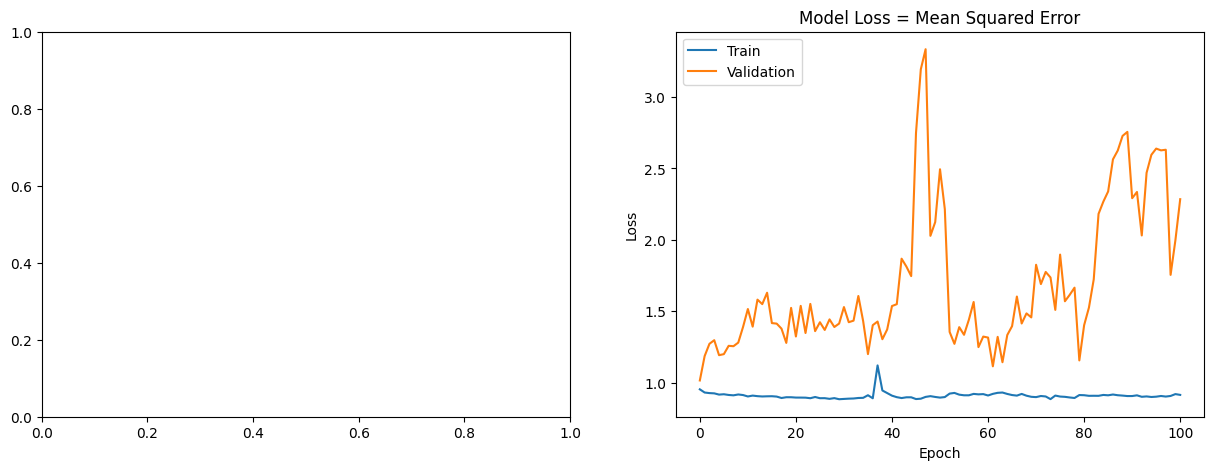

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ax1.plot(history.history['r_square'])
# ax1.plot(history.history['val_r_square'])
# ax1.set_title('Model r_square')
# ax1.set_ylabel('r_square')
# ax1.set_xlabel('Epoch')
# ax1.legend(['Train', 'Validation'], loc='upper left')


ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss = Mean Squared Error')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [ ]:
checkpoint_path = PATH + 'best_model_earlyStop.hdf5'
loaded_model = load_model(checkpoint_path)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

y_train_predict = loaded_model.predict(x_train)
y_train_predict_class = np.argmax(y_train_predict, axis=1)
lb = LabelBinarizer()
y_train_class_bin = lb.fit_transform(y_train)
y_train_class_predict_bin = lb.transform(y_train_predict_class)

y_val_predict = loaded_model.predict(x_val)
y_val_predict_class = np.argmax(y_val_predict, axis=1)
lb = LabelBinarizer()
y_val_class_bin = lb.fit_transform(y_val)
y_val_class_predict_bin = lb.transform(y_val_predict_class)

y_test_predict = loaded_model.predict(x_test)
y_test_predict_class = np.argmax(y_test_predict, axis=1)
lb = LabelBinarizer()
y_test_class_bin = lb.fit_transform(y_test)
y_test_class_predict_bin = lb.transform(y_test_predict_class)

def printResults(expected, result, expected_bin, result_bin):
  accuracy = accuracy_score(expected, result)
  precision = precision_score(expected, result, average=None)
  recall = recall_score(expected, result, average=None)
  f1 = f1_score(expected, result, average=None)
  auc = roc_auc_score(expected_bin, result_bin, average=None)
  average_precision = precision_score(expected, result, average='micro')
  average_recall = recall_score(expected, result, average='micro')
  average_f1 = f1_score(expected, result, average='micro')
  average_auc = roc_auc_score(expected_bin, result_bin, average='micro')
  print("Métricas por classe:")
  print("Precisão:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1)
  print("AUC Médio:", auc)
  print()
  print("Média das métricas:")
  print("Acurácia:", accuracy)
  print("Precisão:", average_precision)
  print("Recall:", average_recall)
  print("F1-Score:", average_f1)
  print("AUC Médio:", average_auc)
  print()

print('----- Métricas de Classificação -----')
print('------------- Train -------------')
printResults(y_train, y_train_predict_class, y_train_class_bin, y_train_class_predict_bin)
print('----------- Validation ----------')
printResults(y_val, y_val_predict_class, y_val_class_bin, y_val_class_predict_bin)
print('------------- Test -------------')
printResults(y_test, y_test_predict_class, y_test_class_bin, y_test_class_predict_bin)
# val_accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_predict_class)

# # Precisão, Recall e F-Score (para cada classe)
# precision = precision_score(np.argmax(y_val, axis=1), y_val_predict_class, average=None)
# recall = recall_score(np.argmax(y_val, axis=1), y_val_predict_class, average=None)
# f1 = f1_score(np.argmax(y_val, axis=1), y_val_predict_class, average=None)



21/21 [==============================] - 0s 13ms/step
----- Métricas de Classificação -----
------------- Train -------------
Métricas por classe:
Precisão: [0.         0.60542432 0.        ]
Recall: [0. 1. 0.]
F1-Score: [0.         0.75422343 0.        ]
AUC Médio: [0.5 0.5 0.5]

Média das métricas:
Acurácia: 0.605424321959755
Precisão: 0.605424321959755
Recall: 0.605424321959755
F1-Score: 0.605424321959755
AUC Médio: 0.7040682414698163

----------- Validation ----------
Métricas por classe:
Precisão: [0.         0.54907975 0.        ]
Recall: [0. 1. 0.]
F1-Score: [0.         0.70891089 0.        ]
AUC Médio: [0.5 0.5 0.5]

Média das métricas:
Acurácia: 0.549079754601227
Precisão: 0.549079754601227
Recall: 0.549079754601227
F1-Score: 0.549079754601227
AUC Médio: 0.6618098159509204

------------- Test -------------
Métricas por classe:
Precisão: [0.         0.71712538 0.        ]
Recall: [0. 1. 0.]
F1-Score: [0.         0.83526269 0.        ]
AUC Médio: [0.5 0.5 0.5]

Média das métrica

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

# Transforme as classes reais e previstas em rótulos binários
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_test_predict_bin = lb.transform(y_test_predict_class)

accuracy = accuracy_score(y_test, y_test_predict_class)
# Precisão, Recall e F1-Score (para cada classe)
precision = precision_score(y_test, y_test_predict_class, average=None)
recall = recall_score(y_test, y_test_predict_class, average=None)
f1 = f1_score(y_test, y_test_predict_class, average=None)
auc = roc_auc_score(y_test_bin, y_test_predict_bin, average=None)

average_precision = precision_score(y_test, y_test_predict_class, average='micro')
average_recall = recall_score(y_test, y_test_predict_class, average='micro')
average_f1 = f1_score(y_test, y_test_predict_class, average='micro')
average_auc = roc_auc_score(y_test_bin, y_test_predict_bin, average='micro')

# Calcule o AUC médio para todas as classes

print("Métricas por classe:")
print("Precisão:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC Médio:", auc)
print()
print("Média das métricas:")
print("Acurácia:", accuracy)
print("Precisão:", average_precision)
print("Recall:", average_recall)
print("F1-Score:", average_f1)
print("AUC Médio:", average_auc)
print()

Métricas por classe:
Precisão: [0.         0.71712538 0.        ]
Recall: [0. 1. 0.]
F1-Score: [0.         0.83526269 0.        ]
AUC Médio: [0.5 0.5 0.5]

Média das métricas:
Acurácia: 0.7171253822629969
Precisão: 0.7171253822629969
Recall: 0.7171253822629969
F1-Score: 0.7171253822629969
AUC Médio: 0.7878440366972478



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


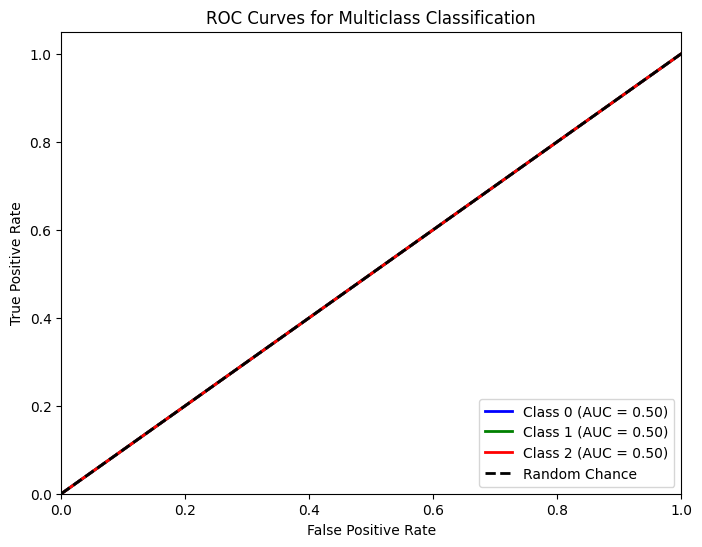

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plotROC(y_true, y_score, class_names):
    n_classes = len(class_names)

    # Inicialize a figura do gráfico
    plt.figure(figsize=(8, 6))

    # Defina as cores para as curvas ROC
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Plote as curvas ROC para cada classe
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

    # Plot the random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiclass Classification')
    plt.legend(loc='lower right')
    plt.show()

# Supondo que y_test_class_bin e y_test_class_predict_bin são matrizes com as probabilidades das classes
class_names = [0, 1, 2]  # Nomes das classes ou rótulos
plotROC(y_test_class_bin, y_test_class_predict_bin, class_names)


In [ ]:
# def build_multilayer_lstm_model(hp):
#   model = keras.Sequential()
#   model.add(LSTM(
#       units=hp.Int('num_lstm_units', min_value=16, max_value=128, step=16),
#       return_sequences=True,
#       input_shape = (x_train.shape[1], x_train.shape[2]),
#       # activation = 'softmax'
#       ))
#   model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4)))
#   model.add(LSTM(
#       units=hp.Int('num_lstm_units', min_value=16, max_value=128, step=16),
#       input_shape = (x_train.shape[1], x_train.shape[2]),
#       # activation = 'softmax'
#       ))
#   Dense(hp.Choice('units_dense', [16, 32, 64]), hp.Choice('activation', ['tanh'])),
#   model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4)))
#   model.add(Dense(units=3, activation='softmax'))